In [1]:
suppressPackageStartupMessages(library(clusterProfiler))
library(cowplot)
library(tidyverse)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443', 'Raw' = 'gray70')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS', 'Raw')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
palette_yn = c("Yes" = "#91cf60", "No" = "#d6604d")

summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.2.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()
✖ purrr::simplify() masks clusterProfiler::simplify()


# Figure 1

In [2]:
fct_feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
fct_causal <- c('5 causal', '10 causal', '20 causal')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples')),
           causal_txt = factor(paste(causal, 'causal'), levels = fct_causal),
           features_txt = factor(paste(features, 'features'), levels = fct_feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

features <- read_tsv('../results/benchmark/random_feature_selection.tsv', 
                     col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

options(repr.plot.width=8, repr.plot.height=8)
fig1 <- ggplot(features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom',
          panel.grid.minor = element_blank()) + 
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(causal_txt ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)

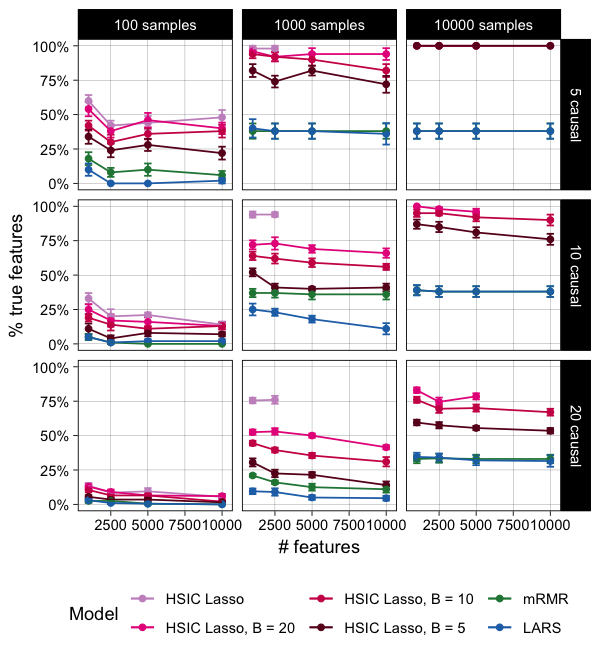

In [3]:
ggsave('img/figure_1.pdf', fig1, width = 5.5, height = 6)
options(repr.plot.width = 5, repr.plot.height = 5.5)
fig1

# Figure 2

In [4]:
pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- summarize_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- summarize_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- summarize_benchmark('../results/asu/warpPIE10P_prediction.tsv')

prediction_img <- bind_rows(pixraw10P, warpAR10P, orlraws10P, warpPIE10P) %>%
    mutate(model = factor(model, levels = methods))

face_recognition <- prediction_img %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_img, model == 'Raw'), aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_linedraw() +
        theme(legend.position = 'none',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank()) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)

In [5]:
CLLSUB111 <- summarize_benchmark('../results/asu/CLL-SUB-111_prediction.tsv')
tox171 <- summarize_benchmark('../results/asu/TOX-171_prediction.tsv')

prediction_ma <- bind_rows(CLLSUB111, tox171) %>%
    mutate(model = factor(model, levels = methods))

ma <- prediction_ma %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_ma, model == 'Raw'), aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_linedraw() +
        theme(legend.position = 'none',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank()) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label, nrow = 2)

legend <- get_legend(ma + theme(legend.position = 'bottom'))

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_path).”

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_path).”

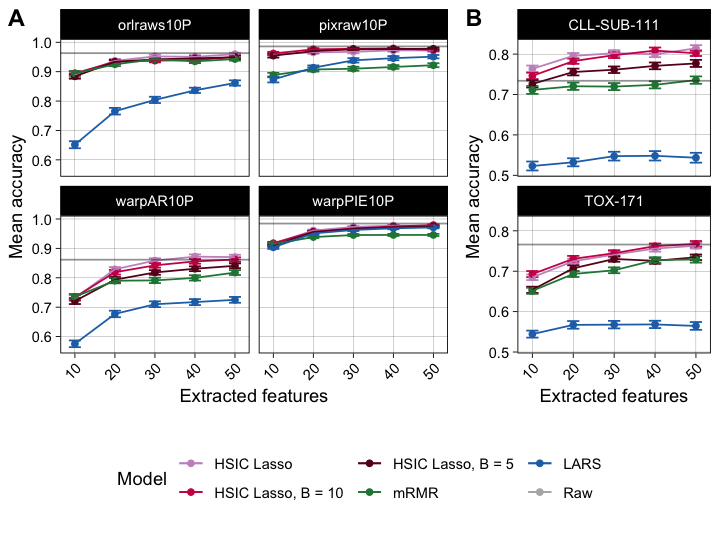

In [6]:
fig2 <- plot_grid(face_recognition, ma, labels = c('A', 'B'), rel_widths = c(2,1.15))
fig2 <- plot_grid(fig2, legend, rel_heights = c(1, .3), nrow = 2)
ggsave('img/figure_2.pdf', fig2, width = 6, height = 4.5)
options(repr.plot.width = 6, repr.plot.height = 4.5)
fig2

# Figure 4

In [7]:
read_predictions <- function(label) {
    
    x <- bind_rows(read_tsv(paste0('../results/single_cell/', label, '_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'HSIC Lasso') %>% head(n = 20),
          read_tsv(paste0('../results/single_cell/', label, '_lars_C=20.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'LARS'),
          read_tsv(paste0('../results/single_cell/', label, '_mrmr_C=20.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'mRMR'))
    
    # number of features selected
    print(table(x$Method))

    # number of features selected by more than one method
    x %>%
        group_by(Gene) %>%
        summarize(n = as.character(n())) %>%
        filter(n > 1) %>%
        print
    
    return(x)
    
}

gene2pathway <- function(genes, pathways) {
    
    rank <- inner_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        group_by(ont) %>%
        summarize(n = length(unique(Method)))

    left_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        left_join(rank, by = "ont") %>%
        arrange(-n) %>%
        group_by(Gene, Method) %>%
        summarize(ont = head(ont, 1)) %>%
        ungroup
    
}

plot_pathways <- function(genes, pathways) {
    
    gene2pathway(genes, pathways) %>%
        filter(!is.na(ont)) %>%
        group_by(ont) %>%
        filter(length(unique(Method)) >= 2) %>%
        ungroup %>%
        ggplot(aes(fct_infreq(ont), fill = Method)) +
            geom_bar() + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position = 'bottom') +
            labs(x = '', y = 'Count') +
            coord_flip() +
            scale_fill_manual(values = palette)
    
}

In [8]:
habib <- read_predictions('habib')

pathways_mouse <- suppressPackageStartupMessages(
    read.gmt(gmtfile = "../data/Mus_musculus_GSEA_GO_sets_bp_symbols_highquality_April_2015.gmt")) %>%
    mutate(ont = gsub('\\([0-9]\\)', '', ont),
           gene = tools::toTitleCase(tolower(gene)),
           ont = tools::toTitleCase(ont),
           ont = gsub('_', ' ', ont))


HSIC Lasso       LARS       mRMR 
        20         16         20 
# A tibble: 0 x 2
# ... with 2 variables: Gene <chr>, n <chr>


In [9]:
markers <- c(read_tsv('~/data/single_cell/habib/Major_cell_types_marker_genes.txt',
                      col_types = 'cddddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/Glia_subcluster_marker_genes.txt',
                         col_types = 'cdddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/GABAergic_edit_subcluster_marker_gene.txt',
                         col_types = 'cdddddddd') %>% .$`GENE NAMES`)

markers_pwy <- data_frame(Gene = markers, Method = 'Known genes') %>%
    gene2pathway(pathways_mouse) %>%
    .$ont %>%
    unique %>%
    na.omit

known_genes <- habib %>% 
    mutate(known_gene = ifelse(Gene %in% markers, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_gene)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known gene?') +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank())

known_pwy <- gene2pathway(habib, pathways_mouse) %>%
    mutate(known_pwy = ifelse(ont %in% markers_pwy, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_pwy)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known BP?') +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank())

fig3 <- plot_grid(known_genes, known_pwy, labels = c('A','B'))

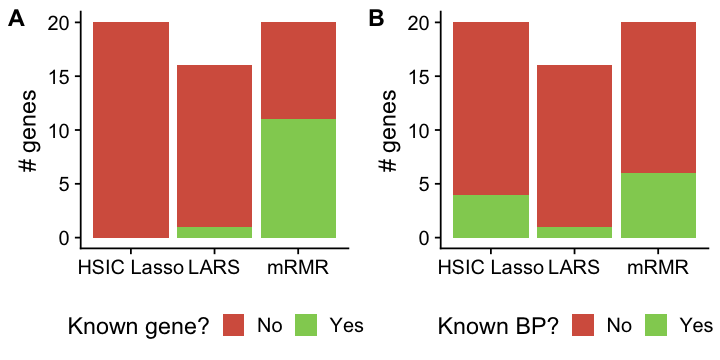

In [10]:
ggsave('img/figure_3.pdf', fig3, width = 6.8, height = 3.8)
options(repr.plot.width=6, repr.plot.height=3)
fig3